In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import networkx as nx
from sklearn.decomposition import PCA
from scipy import sparse

from local_SE import *

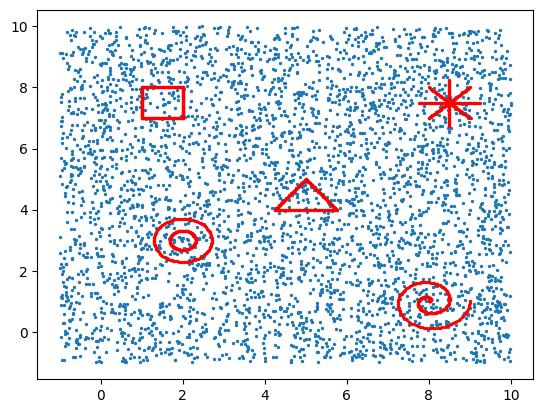

In [3]:
N = 4000
x_random = np.random.uniform(-1, 10, N)
y_random = np.random.uniform(-1, 10, N)
plt.scatter(x_random, y_random, s=2)

# plot a scatter plot of concentric circles in red (center (2,3))
theta = np.linspace(0, 2*np.pi, 100)
r = np.sqrt(0.5)
x_circle_1 = r*np.cos(theta) + 2
y_circle_1 = r*np.sin(theta) + 3

r = np.sqrt(0.1)
x_circle_2 = r*np.cos(theta) + 2
y_circle_2 = r*np.sin(theta) + 3

plt.scatter(x_circle_1, y_circle_1, color='red', s=2)
plt.scatter(x_circle_2, y_circle_2, color='red', s=2)

# plot a scatter plot of a spiral in red
r = np.linspace(0, 1, 200)
theta = 4 * np.pi * r 
x_spiral = r * np.cos(theta) + 8
y_spiral = r * np.sin(theta) + 1
plt.scatter(x_spiral, y_spiral, color='red', s=2)

# plot a scatter plot of an equalateral triangle in red with center at (5,4.5)
x_triangle1 = np.linspace(4.25, 5.75, 50)
y_triangle1 = np.zeros(50) + 4
x_triangle2 = np.linspace(4.25, 5, 50)
y_triangle2 = np.linspace(4, 5, 50)
x_triangle3 = np.linspace(5, 5.75, 50)
y_triangle3 = np.linspace(5, 4, 50)
x_triangle_full = np.concatenate((x_triangle1, x_triangle2, x_triangle3))
y_triangle_full = np.concatenate((y_triangle1, y_triangle2, y_triangle3))
plt.scatter(x_triangle_full, y_triangle_full, color='red', s=2)


#plot a scatter plot of a square in red, with the center at (1.5,7.5)
x_square = np.linspace(0, 1, 50)
y_square = np.zeros(50)
x_square_full = np.concatenate((x_square+1, x_square+1, y_square+2, y_square+1))
y_square_full = np.concatenate((y_square+7, y_square+8, x_square+7, x_square+7))
plt.scatter(x_square_full, y_square_full, color='red', s=2)

#plot an asterisk in red with center at (8.5, 7.5)
x_star1= np.linspace(8, 9, 50)
y_star1 = -x_star1 + 16
x_star2= np.linspace(8, 9, 50)
y_star2 = x_star2 - 1
x_star3 = np.zeros(50) + 8.5
y_star3= np.linspace(6.75, 8.25, 50)
x_star4 = np.linspace(7.75, 9.25, 50)
y_star4 = np.zeros(50) + 7.5

x_star_full = np.concatenate((x_star1, x_star2, x_star3, x_star4))
y_star_full = np.concatenate((y_star1, y_star2, y_star3, y_star4))
plt.scatter(x_star_full, y_star_full, color='red', s=2)

plt.show()



In [4]:
x_shapes = np.concatenate((x_circle_1, x_circle_2, x_spiral, x_triangle_full, x_square_full, x_star_full))
y_shapes = np.concatenate((y_circle_1, y_circle_2, y_spiral, y_triangle_full, y_square_full, y_star_full))
x = np.concatenate((x_random, x_shapes))
y = np.concatenate((y_random, y_shapes))

data = np.column_stack((x, y))

In [5]:
def rbf_kernel(x, y, sigma):
    return np.exp(-np.linalg.norm(x-y)**2/(2*sigma**2))

sigma = 1
n = len(x)
K = np.zeros((n, n))
A = np.zeros((n, n))
for i in range(n):
    for j in range(i):
        K[i, j] = rbf_kernel(data[i], data[j], sigma)
        K[j, i] = K[i, j]
        A[i, j] = stats.bernoulli.rvs(K[i, j])
        A[j, i] = A[i, j]

In [7]:
A = sparse.csr_matrix(A)  

In [8]:
### Uncomment the shape below that you want LASE to focus on ###

# z = np.array([2,3]) # center of the circle

# z = np.array([5,4.5]) # center of the triangle

# z = np.array([8,1]) # center of the spiral

z = np.array([1.5,7.5]) # center of the square

# z= np.array([8.5,7.5]) # center of the star

In [9]:
# find the index of nodes within a radius of z
radius = 1
nodes = np.where(np.linalg.norm(data - z, axis=1) < radius)[0]
blue_nodes = sum(nodes < N)
m = len(nodes)

0.0029492815350385614


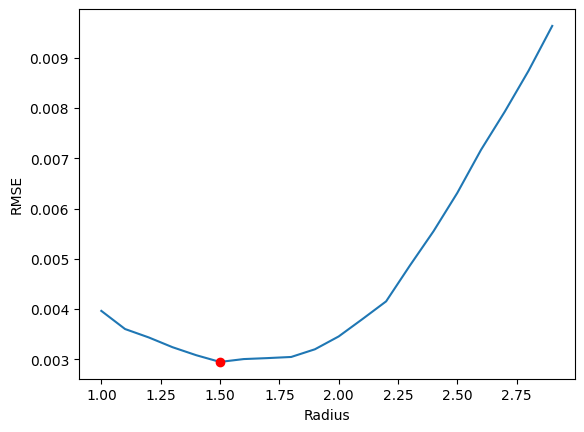

In [10]:
RMSEs = []

values = np.arange(0,2,0.1)

for k in values:
    subgraph_nodes = np.where(np.linalg.norm(data - z, axis=1) < radius + k)[0]
    X_subgraph = sparse_SE(A[subgraph_nodes][:, subgraph_nodes], 3)
    pca = PCA(n_components=2)
    X_subgraph_pca = pca.fit_transform(X_subgraph)

    P_hat_subgraph = X_subgraph @ X_subgraph.T
    np.fill_diagonal(P_hat_subgraph, 0)

    idx = np.where(np.isin(subgraph_nodes, nodes))[0]
    subgraph_RMSE = sum(sum((P_hat_subgraph[idx][:,idx] - K[nodes][:,nodes])**2)) / m**2
    RMSEs.append(subgraph_RMSE)

#find the optimal radius
optimal_radius = values[np.argmin(RMSEs)]

#plot the results
plt.plot(1+values, RMSEs)
plt.plot(1+optimal_radius, min(RMSEs), 'ro')
plt.xlabel('Radius')
plt.ylabel('RMSE')

subgraph_RMSE = min(RMSEs)
print(subgraph_RMSE)

In [11]:
subgraph_nodes = np.where(np.linalg.norm(data - z, axis=1) < radius + optimal_radius)[0]
idx = np.where(np.isin(subgraph_nodes, nodes))[0]
X_subgraph = sparse_SE(A[subgraph_nodes][:, subgraph_nodes], 3)
pca = PCA(n_components=2)
X_subgraph_pca = pca.fit_transform(X_subgraph[idx])

In [12]:
%matplotlib inline

X_global = sparse_SE(A, 3)

# perform pca into 2d on X_local
pca = PCA(n_components=2)
X_global_pca = pca.fit_transform(X_global[nodes])

Text(0.5, 0, 'tau')

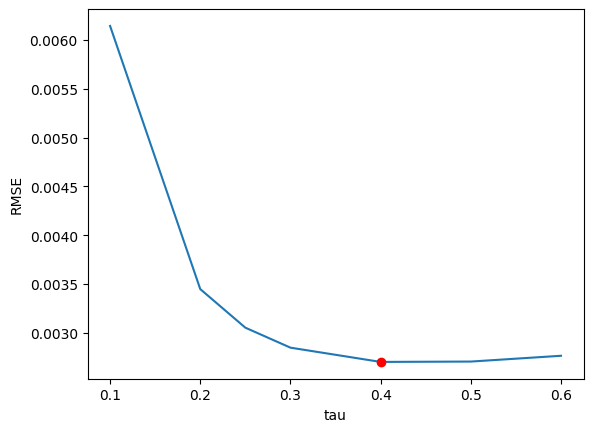

In [13]:
taus = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]
RMSEs = np.zeros(len(taus))

for tau in taus:
    weights = np.zeros(n)
    for i in range(n):
        weights[i] = np.exp( - tau*np.linalg.norm(data[i]-z)**2)
    weights = weights / np.mean(weights)

    X_local = local_embedding(A, 3, weights)
    pca = PCA(n_components=2)
    X_local_pca = pca.fit_transform(X_local[nodes])

    P_hat_LASE = X_local @ X_local.T
    np.fill_diagonal(P_hat_LASE, 0)
    LASE_RMSE = sum(sum((P_hat_LASE[nodes][:,nodes] - K[nodes][:,nodes])**2)) / m**2
    RMSEs[taus.index(tau)] = LASE_RMSE

# find the tau that minimizes the RMSE
tau = taus[np.argmin(RMSEs)]

plt.plot(taus, RMSEs)
plt.plot(tau, min(RMSEs), 'ro')

plt.ylabel('RMSE')
plt.xlabel('tau')



In [14]:
weights = np.zeros(n)
for i in range(n):
    weights[i] = np.exp( - tau*np.linalg.norm(data[i]-z)**2)

weights = weights / np.mean(weights)

In [15]:
X_local = local_embedding(A, 3, weights)

# perform pca into 2d on X_local
pca = PCA(n_components=2)
X_local_pca = pca.fit_transform(X_local[nodes])

In [16]:
# calculate the reconstruction error
m = len(nodes)
P_hat_ASE = X_global @ X_global.T
np.fill_diagonal(P_hat_ASE, 0)
ASE_RMSE = sum(sum((P_hat_ASE[nodes][:,nodes] - K[nodes][:,nodes])**2)) / m**2
print(f'ASE RMSE: {ASE_RMSE}')

P_hat_subgraph = X_subgraph @ X_subgraph.T
np.fill_diagonal(P_hat_subgraph, 0)
subgraph_RMSE = sum(sum((P_hat_subgraph[idx][:,idx] - K[nodes][:,nodes])**2)) / m**2
print(f'Subgraph RMSE: {subgraph_RMSE}')

P_hat_LASE = X_local @ X_local.T
np.fill_diagonal(P_hat_LASE, 0)
LASE_RMSE = sum(sum((P_hat_LASE[nodes][:,nodes] - K[nodes][:,nodes])**2)) / m**2
print(f'LASE RMSE: {LASE_RMSE}')

ASE RMSE: 0.4877861618669041
Subgraph RMSE: 0.0029492815350385597
LASE RMSE: 0.002701174673421055


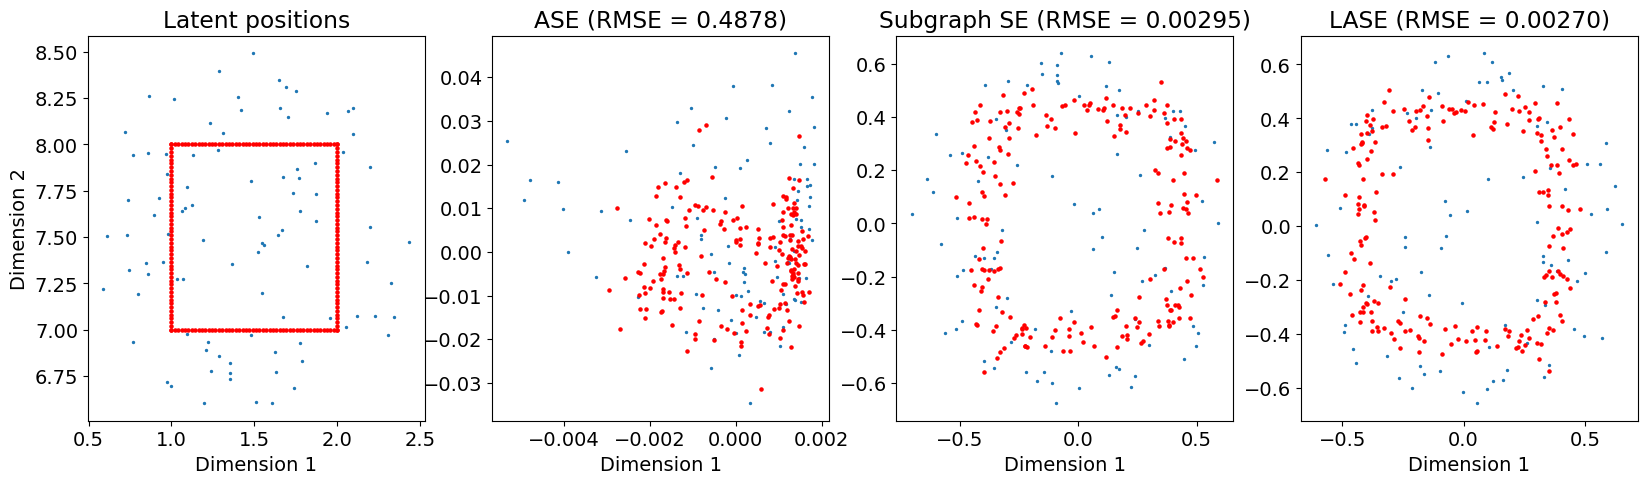

In [ ]:
import matplotlib as mpl

mpl.rcParams.update({'font.size': 14})  

%matplotlib inline
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Data[nodes] plot
axs[0].scatter(data[nodes, 0][0:blue_nodes], data[nodes, 1][0:blue_nodes], s=2)
axs[0].scatter(data[nodes, 0][blue_nodes:], data[nodes, 1][blue_nodes:], color='red', s=5)
axs[0].set_title('Latent positions')
axs[0].set_xlabel('Dimension 1')
axs[0].set_ylabel('Dimension 2')

# Global SE plot
axs[1].scatter(X_global_pca[0:blue_nodes, 1], -X_global_pca[0:blue_nodes, 0], s=2)
axs[1].scatter(X_global_pca[blue_nodes:, 1], -X_global_pca[blue_nodes:, 0], color='red', s=5)
axs[1].set_title('ASE (RMSE = {:.4f})'.format(ASE_RMSE))
axs[1].set_xlabel('Dimension 1')

# Subgraph SE plot
axs[2].scatter(X_subgraph_pca[0:blue_nodes, 1], -X_subgraph_pca[0:blue_nodes, 0], s=2)
axs[2].scatter(X_subgraph_pca[blue_nodes:, 1], -X_subgraph_pca[blue_nodes:, 0], color='red', s=5)
axs[2].set_title('Subgraph SE (RMSE = {:.5f})'.format(subgraph_RMSE))
axs[2].set_xlabel('Dimension 1')

# Local SE plot
axs[3].scatter(X_local_pca[0:blue_nodes, 1], -X_local_pca[0:blue_nodes, 0], s=2)
axs[3].scatter(X_local_pca[blue_nodes:, 1], -X_local_pca[blue_nodes:, 0], color='red', s=5)
axs[3].set_title('LASE (RMSE = {:.5f})'.format(LASE_RMSE))
axs[3].set_xlabel('Dimension 1')

plt.show()

